# 소프트맥스 회귀의 비용함수 구현

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

## 로우-레벨

In [2]:
z = torch.FloatTensor([1, 2, 3])
h = F.softmax(z, dim=0)
h, h.sum() # 소프트맥스 함수의 출력합은 1

(tensor([0.0900, 0.2447, 0.6652]), tensor(1.))

In [3]:
z = torch.rand(3, 5, requires_grad=True)
h = F.softmax(z, dim=1)
h, h.sum(axis=1) # 행별 원소합 1

(tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
         [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
         [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>),
 tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>))

In [4]:
y = torch.randint(5, (3, )).long()
y, y.unsqueeze(1) # (3,) -> (3, 1)

(tensor([0, 2, 1]),
 tensor([[0],
         [2],
         [1]]))

In [5]:
y_one_hot = torch.zeros_like(h) # 3x5 텐서생성
y_one_hot.scatter_(1, y.unsqueeze(1), 1) # dim, 위치, 넣을 숫자

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [6]:
cost = (y_one_hot * -torch.log(h)).sum(dim=1).mean()
cost

tensor(1.4689, grad_fn=<MeanBackward0>)

## 하이-레벨

### 1. F.softmax() + torch.log() = F.log_softmax()

In [7]:
torch.log(F.softmax(z, dim=1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward0>)

In [8]:
F.log_softmax(z, dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

### 2. F.log_softmax() + F.nll_loss = F.cross_entropy()

In [9]:
(y_one_hot * -torch.log(h)).sum(dim=1).mean()


tensor(1.4689, grad_fn=<MeanBackward0>)

In [10]:
(y_one_hot * -F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [11]:
F.nll_loss(F.log_softmax(z, dim=1), y) # 원핫벡터 없이 실제값 입력

tensor(1.4689, grad_fn=<NllLossBackward0>)

In [12]:
F.cross_entropy(z, y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

# 소프트맥스 회귀 구현

In [13]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

x_train.shape, y_train.shape

(torch.Size([8, 4]), torch.Size([8]))

## 1. 로우-레벨

In [14]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
y_one_hot.shape

torch.Size([8, 3])

In [15]:
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
o = optim.SGD([W, b], lr=0.1)

epochs = 10
for epoch in range(epochs + 1):
    h = F.softmax(x_train.matmul(W) + b, dim=1)
    c = (y_one_hot * -torch.log(h)).sum(dim=1).mean()
    
    o.zero_grad()
    c.backward()
    o.step()
    
    print(f'epoch {epoch}/{epochs}, cost: {c.item():6f}')

epoch 0/10, cost: 1.098612
epoch 1/10, cost: 1.032776
epoch 2/10, cost: 0.985576
epoch 3/10, cost: 0.967064
epoch 4/10, cost: 0.966850
epoch 5/10, cost: 0.985291
epoch 6/10, cost: 1.032398
epoch 7/10, cost: 1.047309
epoch 8/10, cost: 1.091330
epoch 9/10, cost: 1.030259
epoch 10/10, cost: 1.069288


## 2. 하이-레벨

In [16]:
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
o = optim.SGD([W, b], lr=0.1)

epochs = 10
for epoch in range(epochs + 1):
    z = x_train.matmul(W) + b
    c = F.cross_entropy(z, y_train)
    
    o.zero_grad()
    c.backward()
    o.step()
    
    print(f'epoch {epoch}/{epochs}, cost: {c.item():6f}')

epoch 0/10, cost: 1.098612
epoch 1/10, cost: 1.032775
epoch 2/10, cost: 0.985576
epoch 3/10, cost: 0.967064
epoch 4/10, cost: 0.966850
epoch 5/10, cost: 0.985291
epoch 6/10, cost: 1.032399
epoch 7/10, cost: 1.047309
epoch 8/10, cost: 1.091330
epoch 9/10, cost: 1.030258
epoch 10/10, cost: 1.069288


## 3. nn.Module

In [17]:
model = nn.Linear(4, 3) # 입력개수, 클래스개수
o = optim.SGD(model.parameters(), lr=0.1)

epochs = 10
for epoch in range(epochs + 1):
    pred = model(x_train)
    c = F.cross_entropy(pred, y_train)
    
    o.zero_grad()
    c.backward()
    o.step()
    
    print(f'epoch {epoch}/{epochs}, cost: {c.item():6f}')

epoch 0/10, cost: 1.849513
epoch 1/10, cost: 1.298513
epoch 2/10, cost: 1.046181
epoch 3/10, cost: 0.954982
epoch 4/10, cost: 0.929780
epoch 5/10, cost: 0.908864
epoch 6/10, cost: 0.891565
epoch 7/10, cost: 0.877385
epoch 8/10, cost: 0.866827
epoch 9/10, cost: 0.859866
epoch 10/10, cost: 0.859701


## 4. 클래스로 구현

In [18]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3)
    
    def forward(self, x):
        return self.linear(x)

In [19]:
model = SoftmaxClassifierModel()
o = optim.SGD(model.parameters(), lr=0.1)

epochs = 10
for epoch in range(epochs + 1):
    pred = model(x_train)
    c = F.cross_entropy(pred, y_train)
    
    o.zero_grad()
    c.backward()
    o.step()
    
    print(f'epoch {epoch}/{epochs}, cost: {c.item():6f}')

epoch 0/10, cost: 1.845720
epoch 1/10, cost: 1.460510
epoch 2/10, cost: 1.265032
epoch 3/10, cost: 1.231668
epoch 4/10, cost: 1.214960
epoch 5/10, cost: 1.176336
epoch 6/10, cost: 1.106072
epoch 7/10, cost: 1.103787
epoch 8/10, cost: 1.042308
epoch 9/10, cost: 1.056017
epoch 10/10, cost: 0.989940


# 소프트맥스 회귀로 MNIST 데이터 분류

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

In [21]:
# GPU 연산
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [22]:
# 랜덤시드 고정
random.seed(0)
torch.manual_seed(0)
if device == 'cuda':
    torch.cuda.manual_seed_all(0)

In [23]:
# 하이퍼파라미터
training_epochs = 15
batch_size = 100

In [24]:
mnist_train = dsets.MNIST(
    root='MNIST_data', # 다운로드 경로
    train=True,
    transform=transforms.ToTensor(), # 텐서로 변환
    download=True # 데이터셋이 없다면 다운로드
)

mnist_test = dsets.MNIST(
    root='MNIST_data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [25]:
dataloader = DataLoader(
    dataset=mnist_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True # 미니배치보다 개수가 적은 마지막 배치의 과대평가 방지
)

In [26]:
linear = nn.Linear(784, 10, bias=True).to(device) # to()로 연산메모리 설정
linear

Linear(in_features=784, out_features=10, bias=True)

In [27]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [28]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(dataloader)
    
    for X, y in dataloader:
        X = X.view(-1, 28 * 28).to(device) # (100, 784)
        y = y.to(device) # 클래스(원핫x)
        
        hypothesis = linear(X)
        optimizer.zero_grad()
        cost = criterion(hypothesis, y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    print(f'epoch {epoch}/{training_epochs}, cost: {avg_cost:.9f}')

print('learning finished')

epoch 0/15, cost: 0.535949469
epoch 1/15, cost: 0.359360933
epoch 2/15, cost: 0.331327111
epoch 3/15, cost: 0.316370010
epoch 4/15, cost: 0.306923091
epoch 5/15, cost: 0.300204843
epoch 6/15, cost: 0.294921339
epoch 7/15, cost: 0.290828079
epoch 8/15, cost: 0.287171513
epoch 9/15, cost: 0.284261644
epoch 10/15, cost: 0.281829149
epoch 11/15, cost: 0.279674202
epoch 12/15, cost: 0.277828932
epoch 13/15, cost: 0.276153117
epoch 14/15, cost: 0.274277598
learning finished


accuracy: 0.8840000033378601
label: 2
pred: 2


c:\workspace\mlProject\venv\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
c:\workspace\mlProject\venv\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


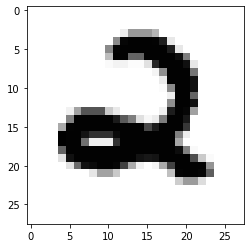

In [29]:
# test data로 모델 테스트
with torch.no_grad(): # gradient 계산 x
    X_test = mnist_test.data.view(-1, 28 * 28).float().to(device)
    y_test = mnist_test.test_labels.to(device)
    
    pred = linear(X_test)
    correct_pred = torch.argmax(pred, 1) == y_test
    acc = correct_pred.float().mean()
    print(f'accuracy: {acc.item()}')
    
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    y_single_data = mnist_test.test_labels[r:r + 1].to(device)
    
    print(f'label: {y_single_data.item()}')
    single_pred = linear(X_single_data)
    print(f'pred: {torch.argmax(single_pred, 1).item()}')
    
    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()